In [ ]:
import time
import numpy as np
from collections import defaultdict

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Set2')

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST

Установим машину, на которой будем обучать модели.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Зафиксируем цветовую палитру.

In [ ]:
pallete = sns.color_palette("Set2")
pallete

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

### 0. Данные
Будем использовать набор данных **Fasion MNIST**. Скачаем тренировочный и тестовый наборы данных.

In [ ]:
train_source = FashionMNIST('fasionmnist', download=True, train=True)
test_source = FashionMNIST('fasionmnist', download=True, train=False)

100%|██████████| 26421880/26421880 [00:02<00:00, 10839335.33it/s]


Extracting fasionmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fasionmnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 174841.65it/s]


Extracting fasionmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fasionmnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3242283.23it/s]


Extracting fasionmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fasionmnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21442181.72it/s]


Extracting fasionmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fasionmnist/FashionMNIST/raw



Он содержит 60 000 изображений в тренировочной части данных и 10 000 в тестовой.

In [ ]:
len(train_source.data), len(test_source.data)

(60000, 10000)

В датасете содержится 10 классов одежды.

In [ ]:
train_source.targets.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Можно посмотреть их названия.

In [ ]:
train_source.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Проиллюстрируем набор данных.

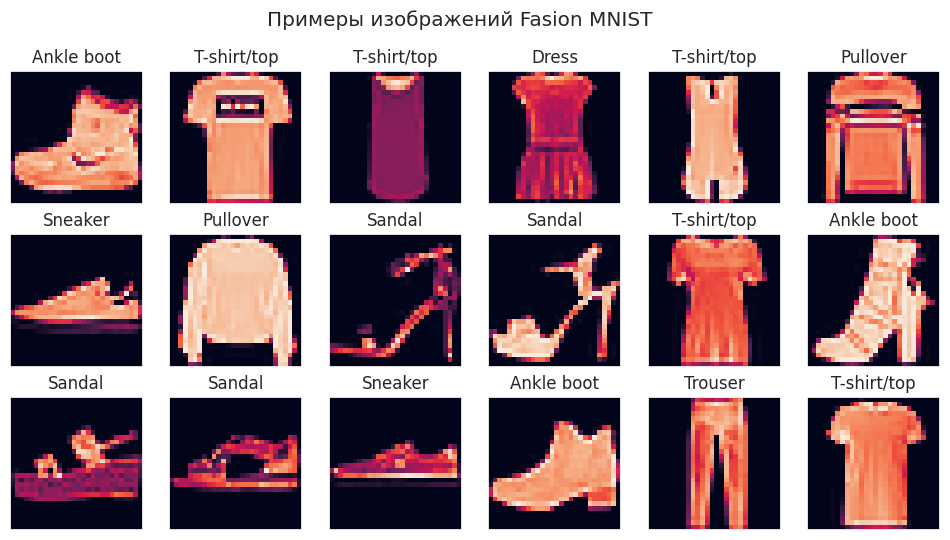

In [ ]:
fig, axs = plt.subplots(3, 6, figsize=(12, 6))
for k, (image, label) in enumerate(zip(train_source.data[:18], train_source.targets[:18])):
    i, j = k // 6, k % 6
    axs[i][j].imshow(image)
    axs[i][j].grid()
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])
    axs[i][j].set_title(train_source.classes[label])
fig.suptitle('Примеры изображений Fasion MNIST')
plt.show()

### 1. Простая полносвязная нейронная сеть

In [ ]:
def train(
        model,
        criterion,
        optimizer,
        train_loader,
        val_loader,
        num_epochs,
        device,
        checkpoint_path=None,
):
    """
    # Обучение модели
    """
    start_time = time.time()
    history = defaultdict(lambda: defaultdict(list))
    best_val_acc = 0.
    model.to(device)

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        train_size, val_size = 0, 0

        model.train()  # устанавливаем поведение dropout / batch_norm  в обучение

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Обучаемся на батче (одна "итерация" обучения нейросети)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.detach() * len(y_batch)
            y_pred = torch.argmax(logits, axis=1).detach()
            train_acc += (y_batch == y_pred).sum()
            train_size += len(y_batch)

        # Подсчитываем лоссы и точность, сохраням в "историю"
        train_loss = train_loss.cpu().numpy() / train_size
        train_acc = train_acc.cpu().numpy() / train_size
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # Устанавливаем поведение dropout / batch_norm  в тестирование
        model.eval()

        # Полный проход по валидации
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                logits = model(X_batch)
                loss = criterion(logits, y_batch)

                val_loss += loss.detach() * len(y_batch)
                y_pred = torch.argmax(logits, axis=1).detach()
                val_acc += (y_batch == y_pred).sum()
                val_size += len(y_batch)

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss = val_loss.cpu().numpy() / val_size
        val_acc = val_acc.cpu().numpy() / val_size
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        # Сохраняем лучшую модель по метрике на валидации
        if (checkpoint_path is not None) and (val_acc > best_val_acc):
            torch.save({
                'model': model.state_dict(),
                'optim': optimizer.state_dict(),
                }, checkpoint_path)
            best_val_acc = val_acc

        clear_output()
        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {}. Total time {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

    return history

Построbv простую полносвязную двухслойную нейронную сеть с функцией активации ReLU. Обучиv ее на тренировочной части данных.

Реализуем класс датасета, для того, чтобы создать генеарторы данных для обучения.

In [ ]:
class SimpleDataset():
    """
    Простой итерериуемый датасет.
    """

    def __init__(self, X_data, y_data):
        assert len(X_data) == len(y_data)
        self.x = X_data
        self.y = y_data

    def __len__(self):
        """
        Размер датасета.
        """

        return len(self.y)

    def __getitem__(self, idx):
        """
        Обращение к элементу датасета по индексу.
        """
        xi = self.x[idx].ravel().to(torch.float32)
        yi = self.y[idx].to(torch.long)
        return xi, yi

Распределим данные из обучаещей и тестовой выборки в соответствующие генераторы.

In [ ]:
batch_size = 64
num_workers = 2

train_dataset = SimpleDataset(train_source.data, train_source.targets)
test_dataset = SimpleDataset(test_source.data, test_source.targets)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

В качестве функции ошибки далее будем использовать кросс-энтропию.

In [ ]:
criterion = nn.CrossEntropyLoss()

Реализуем простую полносвязную двухслойную нейронную сеть.

In [ ]:
model = nn.Sequential(
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
)

Обучим модель.

In [ ]:
history0 = train(
    model,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    num_epochs=30,
    device=device,
    checkpoint_path='task1.pth',
)

Epoch 30 of 30. Total time 130.759s
  training loss (in-iteration): 	0.192487
  validation loss (in-iteration): 	0.423437
  training accuracy: 			92.74 %
  validation accuracy: 			87.83 %


Возьмем функцию для визуализации истории обучения с семинара.

In [ ]:
def plot_histories(histories, names, colors=None):
    sns.set_style('darkgrid')
    if colors==None:
        colors = ['darkblue', 'lightcoral', 'limegreen', 'sandybrown', 'cyan', 'hotpink']
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))

    epochs = np.min([len(h['loss']['train']) for h in histories])
    for i, (history, name) in enumerate(zip(histories, names)):
        axs[0].set_title('Лосс')
        axs[0].plot(history['loss']['train'][:epochs], label=f'{name}', lw=2, c=colors[i])
        axs[0].plot(history['loss']['val'][:epochs], lw=1.5, c=colors[i], ls='--')
        axs[0].set_xlabel('Эпохи')

        axs[1].set_title('Точность')
        axs[1].plot(history['acc']['train'][:epochs], label=f'{name}', lw=2, c=colors[i])
        axs[1].plot(history['acc']['val'][:epochs], lw=1.5, c=colors[i], ls='--')
        axs[1].set_xlabel('Эпохи')
        if name != '':
            axs[1].legend()

    dummy_lines = [axs[0].plot([], [], c='black', lw=2)[0],
                   axs[0].plot([], [], c='black', lw=1.5, ls='--')[0]]
    for i in range(2):
        legend = axs[i].legend(loc=3-i)
        axs[i].legend(dummy_lines, ["train", "val"], loc=4)
        axs[i].add_artist(legend)

Визулизируем историю.

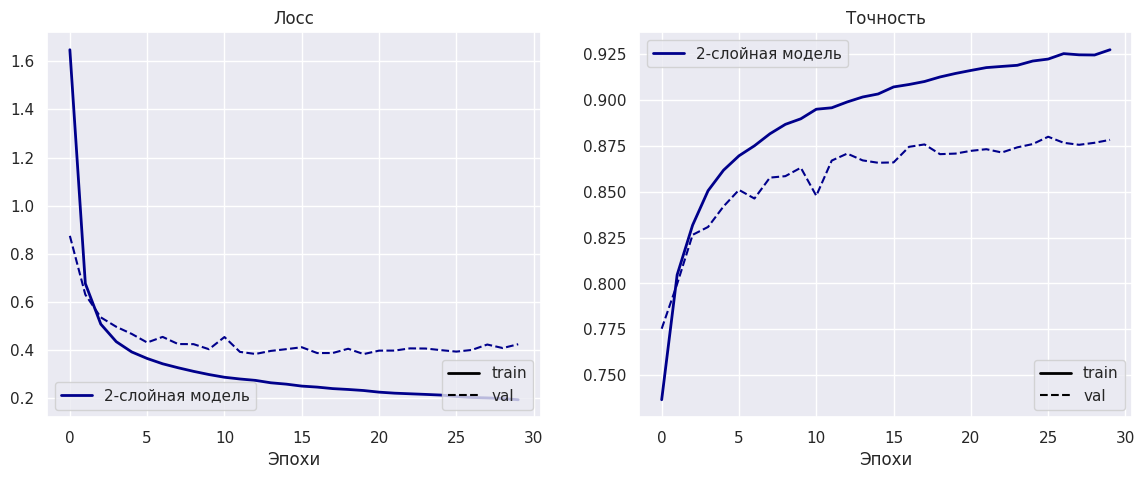

In [ ]:
plot_histories([history0], ['2-слойная модель'])

Визуализируйте "вероятности" предскаазнных моделью классов для нескольких изображений из теста. Для этого нужно применить SoftMax к выходам модели.

In [ ]:
model.eval()

Sequential(
  (0): Linear(in_features=784, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=10, bias=True)
)

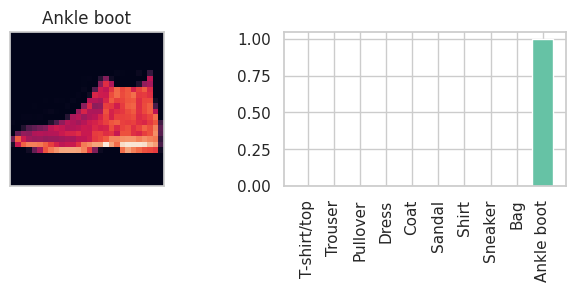

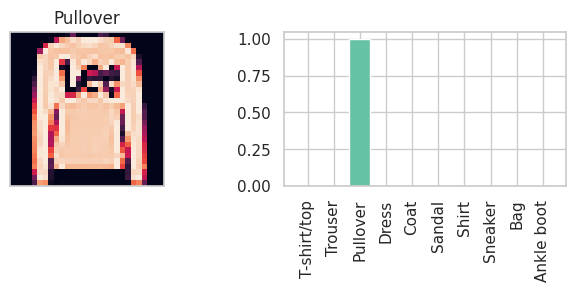

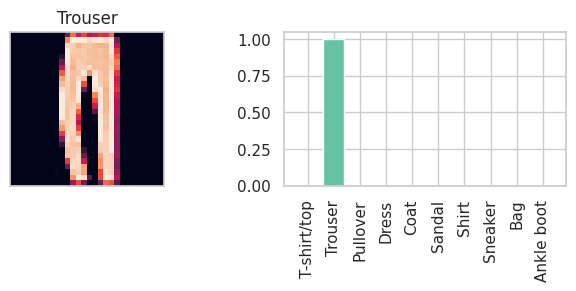

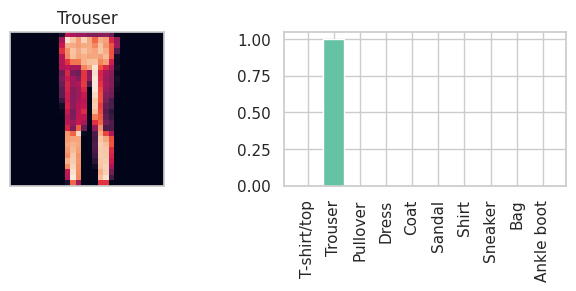

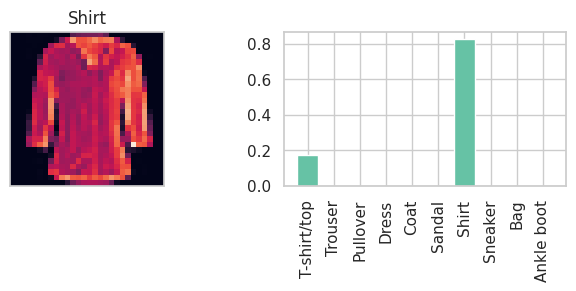

In [ ]:
for i in range(5):
    with sns.axes_style('whitegrid'):
        plt.figure(figsize=(8, 2))

        image, label = test_dataset[i]

        plt.subplot(1, 2, 1)
        plt.imshow(image.reshape(28, 28))
        plt.title(test_source.classes[label.item()])
        plt.xticks([])
        plt.yticks([])

        plt.grid()
        with torch.no_grad():
            logits = model(image.to(device).unsqueeze(0))[0].cpu()
        prob = torch.softmax(logits, dim=0)

        plt.subplot(1, 2, 2)
        plt.bar(test_source.classes, prob)
        plt.xticks(rotation=90)

На данных примерах модель везде очень уверена в своих предсказаниях, кроме последней картинки.

### 2. BatchNorm

Проверbv два варианта включения BatchNorm в архитектуру двухслойной сети: до функции активации и после нее. В итоге получается 2 модели:
```
(1) Linear -> BatchNorm -> ReLU -> Linear
(2) Linear -> ReLU -> BatchNorm -> Linear
```
Обучим обе модели. Построим графики распределений выходов первого, второго и третьего слоя сети (т.е. всех кроме последнего) для каждой модели до обучения, в процессе обучения и после обучения. Сравним эти графики с соответствующими графиками модели без BatchNorm.

Зададим модели, требуемые в условии.

In [ ]:
models = {
    # модель без батч-нормализации
    'no_bn': nn.Sequential(
        nn.Linear(28 * 28, 100),
        nn.ReLU(),
        nn.Linear(100, 10),
    ),
    # модлеи с батч-нормализацией
    'bn_relu': nn.Sequential(
        nn.Linear(28 * 28, 100),
        nn.BatchNorm1d(100),
        nn.ReLU(),
        nn.Linear(100, 10),
    ),
    'relu_bn': nn.Sequential(
        nn.Linear(28 * 28, 100),
        nn.ReLU(),
        nn.BatchNorm1d(100),
        nn.Linear(100, 10),
    ),
}

Реализуем функцию для подсчета выходов первых трех слоев.

In [ ]:
def calc_outputs(model, device):
    model.to(device)
    model.train()
    outputs1, outputs2, outputs3 = [], [], []
    with torch.no_grad():
        for image, _ in train_loader:
            image = image.to(device)
            out1 = model[0](image)
            out2 = model[1](out1)
            out3 = model[2](out2)
            outputs1.append(out1.ravel().cpu())
            outputs2.append(out2.ravel().cpu())
            outputs3.append(out3.ravel().cpu())
    return torch.cat(outputs1), torch.cat(outputs2), torch.cat(outputs3)

Будем записывать выходы модели в `outputs`.

In [ ]:
outputs = {name: {'l1': {}, 'l2': {}, 'l3': {}} for name in ('no_bn', 'bn_relu', 'relu_bn')}

Проведем указанный в условии эксперимент.

In [ ]:
for model_name, model in models.items():
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-4,
    )

    # выходы слоев перед обучением
    model_outputs = calc_outputs(model, device)
    outputs[model_name]['l1']['init'] = model_outputs[0]
    outputs[model_name]['l2']['init'] = model_outputs[1]
    outputs[model_name]['l3']['init'] = model_outputs[2]

    train(
        model,
        criterion,
        optimizer,
        train_loader,
        test_loader,
        num_epochs=3,
        device=device,
    );

    # выходы слоев во время обучения после 3 эпох
    model_outputs = calc_outputs(model, device)
    outputs[model_name]['l1']['train'] = model_outputs[0]
    outputs[model_name]['l2']['train'] = model_outputs[1]
    outputs[model_name]['l3']['train'] = model_outputs[2]

    train(
        model,
        criterion,
        optimizer,
        train_loader,
        test_loader,
        num_epochs=27,
        device=device,
    );

    # выходы слоев после обучения модели
    model_outputs = calc_outputs(model, device)
    outputs[model_name]['l1']['final'] = model_outputs[0]
    outputs[model_name]['l2']['final'] = model_outputs[1]
    outputs[model_name]['l3']['final'] = model_outputs[2]

Epoch 27 of 27. Total time 135.895s
  training loss (in-iteration): 	0.188711
  validation loss (in-iteration): 	0.343968
  training accuracy: 			93.23 %
  validation accuracy: 			88.23 %


Визуализируем распределения выходов.

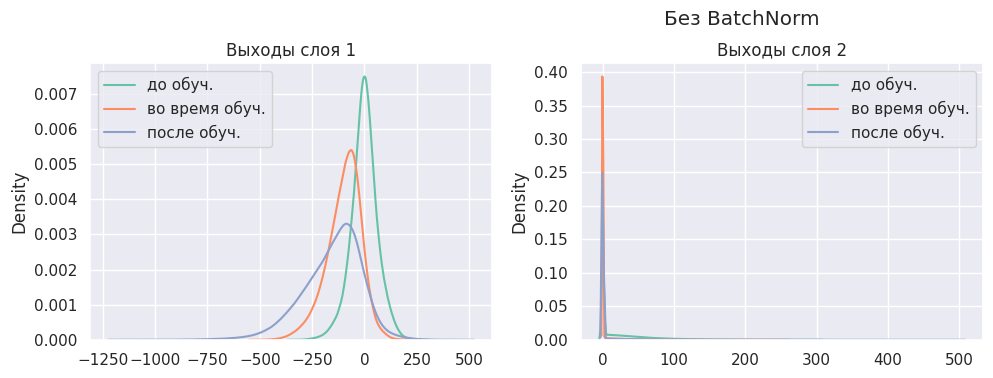

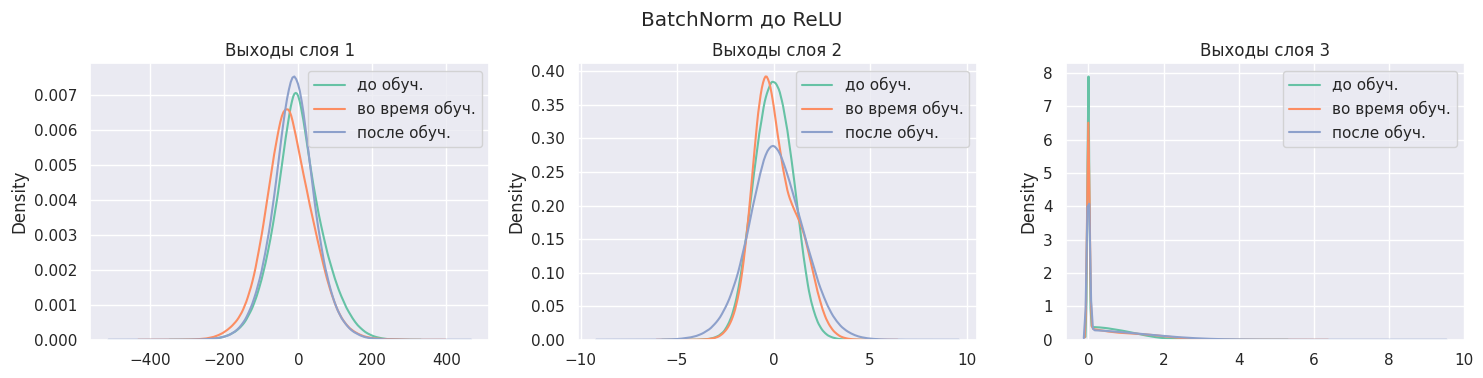

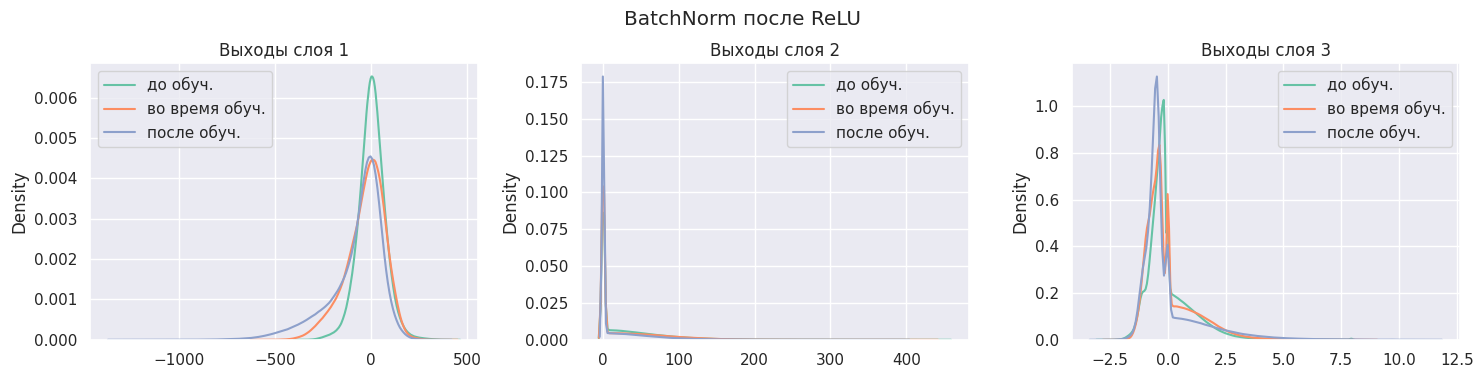

In [ ]:
for model_name, model_rus_name in zip(
        ('no_bn', 'bn_relu', 'relu_bn'),
        ('Без BatchNorm', 'BatchNorm до ReLU', 'BatchNorm после ReLU')
):
    fig = plt.figure(figsize=(15, 4))

    n_layers = 2 if model_name == 'no_bn' else 3
    for i in range(n_layers):
        plt.subplot(1, 3, i + 1)
        sns.kdeplot(outputs[model_name][f'l{i + 1}']['init'], label='до обуч.')
        sns.kdeplot(outputs[model_name][f'l{i + 1}']['train'], label='во время обуч.')
        sns.kdeplot(outputs[model_name][f'l{i + 1}']['final'], label='после обуч.')
        plt.title(f'Выходы слоя {i + 1}')
        plt.legend()

    fig.suptitle(model_rus_name, y=0.94)
    plt.tight_layout()

**Выводы**  
* Без BatchNorm дисперсия выходов первого слоя увеличивается в течение обучения. Появляется небольшой сдвиг в область отрицательных значений. При этом доля околонулевых значений после применения ReLU не высока, а дисперсия большая.
* В случае, когда BatchNorm находится после линейного слоя и до ReLU, распределение выходов первого слоя практически не меняется. Выходы слоя BatchNorm близки к нормальному распределению. Но видно, что в течение обучения дисперсия немного увеличилась: параметр стандартного отклонения так обучился. После ReLU доля около нулевых параметров оказалась большой, но дисперсия значений очень мала.
* В случае, когда BatchNorm находится после ReLU, распределение выходов первого слоя похоже на то, что было в эксперименте без BatchNorm, однако сдвиг в отрицательную сторону получился больше. Больше выходов ReLU с течением обучения становятся близкими к 0, дисперсия выходов достаточно большая. BatchNorm плохо справляется с нормализацией, график распределения выходов BatchNorm мало отличается от графика распределения выходов предыдущего слоя.

BatchNorm эффективно стандартизирует выходы слоя, если они изначально были из нормального распределения. В течение обучения этот эффект сохраняется. В обратном случае эффект нормализации BatchNorm сомнителен.



Обучите оба варианта модели с BatchNorm с разными инициализациями хотя бы 3 раза. Инициализации должны отличаться только random state. Сравните качество моделей по loss и accuracy в зависимости от номера итерации.

In [ ]:
bn_histories = []

Первый вариант модели с батч-нормализацией.

In [ ]:
for i in range(3):
    model = nn.Sequential(
        nn.Linear(28 * 28, 100),
        nn.BatchNorm1d(100),
        nn.ReLU(),
        nn.Linear(100, 10),
    )
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-4,
    )
    bn_histories.append(
        train(
            model,
            criterion,
            optimizer,
            train_loader,
            test_loader,
            num_epochs=30,
            device=device,
        )
    )

Epoch 30 of 30. Total time 127.930s
  training loss (in-iteration): 	0.178398
  validation loss (in-iteration): 	0.328435
  training accuracy: 			93.82 %
  validation accuracy: 			88.41 %


Второй вариант модели с батч-нормализацией.

In [ ]:
for i in range(3):
    model = nn.Sequential(
        nn.Linear(28 * 28, 100),
        nn.ReLU(),
        nn.BatchNorm1d(100),
        nn.Linear(100, 10),
    )
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-4,
    )
    bn_histories.append(
        train(
            model,
            criterion,
            optimizer,
            train_loader,
            test_loader,
            num_epochs=30,
            device=device,
        )
    )

Epoch 30 of 30. Total time 135.105s
  training loss (in-iteration): 	0.193807
  validation loss (in-iteration): 	0.512169
  training accuracy: 			92.99 %
  validation accuracy: 			87.94 %


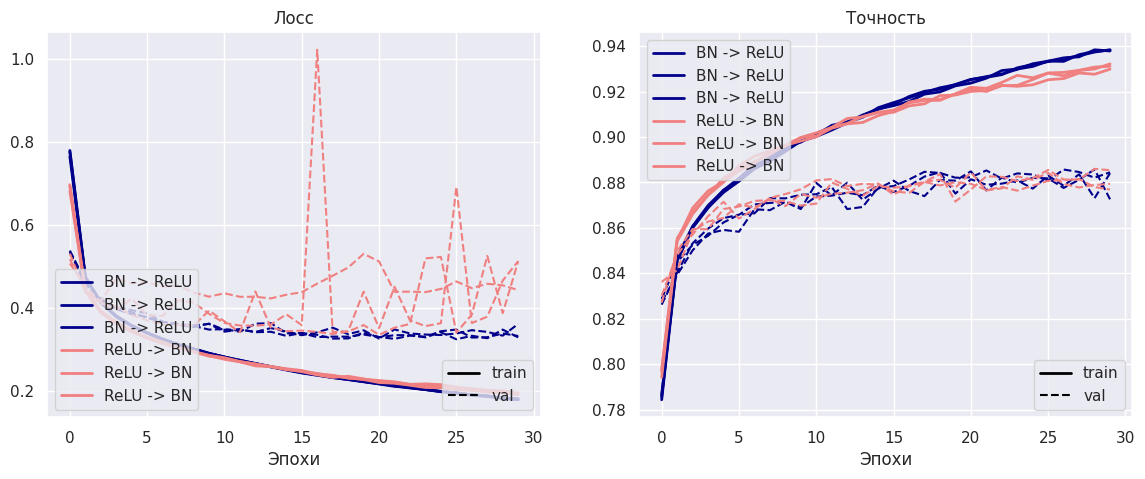

In [ ]:
plot_histories(bn_histories, names=['BN -> ReLU'] * 3 + ['ReLU -> BN'] * 3,
               colors=['darkblue'] * 3 + ['lightcoral'] * 3)

**Вывод**  
Обучение модели в случае, когда BatchNorm находится до ReLU происходило более стабильно и качественно, нежели когда BatchNorm стоял после ReLU. Это можно наблюдать по графику лосса на тестовой выборке. Это можно объяснить тем, что дисперсия выходов для первой модели на всех слоях меньше, чем у второй модели. При этом по точности модели получились похожими. Здесь видно несоответствие между оптимизируемой моделью и метрикой. Так бывает в задачах классификации.

Выберем лучшую обученную модель с BatchNorm. Посмотрим на распределение выходов слоя до BatchNorm и самого BatchNorm для нескольких батчей из тестовой части данных.


Уменьшим размер батча, чтобы отличия в распределениях были более явными.

In [ ]:
batch_size = 16
train_loader_small = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader_small = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

Обучим первый вариант модели с батч-нормализацией.

In [ ]:
model = nn.Sequential(
    nn.Linear(28 * 28, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 10),
)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
)
train(
    model,
    criterion,
    optimizer,
    train_loader_small,
    test_loader_small,
    num_epochs=30,
    device=device,
);

Epoch 30 of 30. Total time 418.599s
  training loss (in-iteration): 	0.210832
  validation loss (in-iteration): 	0.316090
  training accuracy: 			92.55 %
  validation accuracy: 			89.03 %


Посчитаем распределения выходов первого и второго слоя для разных бачтей.

In [ ]:
model.eval()
outputs1 = []
outputs2 = []
for i, (image, _) in enumerate(test_loader):
    if i == 5:
        break
    with torch.no_grad():
        out1 = model[0](image.to(device))
        out2 = model[1](out1)
    outputs1.append(out1.ravel().cpu())
    outputs2.append(out2.ravel().cpu())

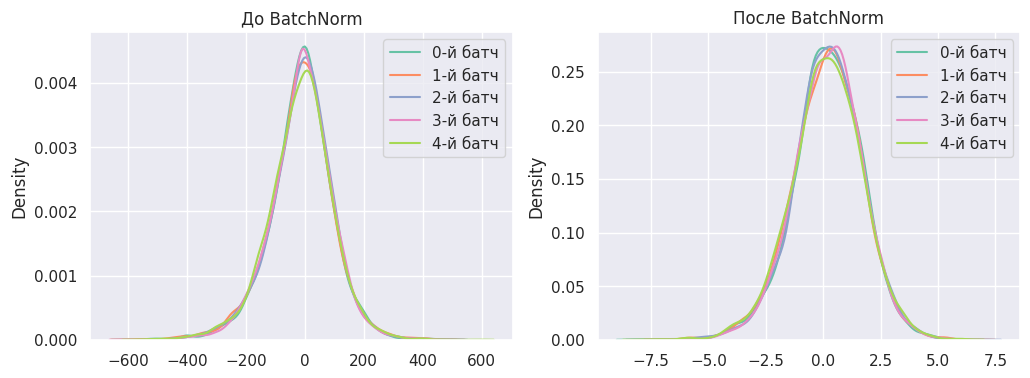

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for i in range(5):
    sns.kdeplot(outputs1[i], label=f'{i}-й батч', ax=axs[0])
    sns.kdeplot(outputs2[i], label=f'{i}-й батч', ax=axs[1])
axs[0].set_title('До BatchNorm')
axs[1].set_title('После BatchNorm')
axs[0].legend()
axs[1].legend()
plt.show()

Распределения между батчами мало отличаются на первом слое, но после BatchNorm отличий также не сильно видно.

Проверим, что с распределениями выходов первого слоя модели без батч-нормализации.

In [ ]:
model = nn.Sequential(
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
)
train(
    model,
    criterion,
    optimizer,
    train_loader_small,
    test_loader_small,
    num_epochs=30,
    device=device,
);

Epoch 30 of 30. Total time 400.144s
  training loss (in-iteration): 	0.219318
  validation loss (in-iteration): 	0.454773
  training accuracy: 			91.80 %
  validation accuracy: 			87.33 %


In [ ]:
model.eval()
outputs1 = []
for i, (image, _) in enumerate(test_loader):
    if i == 5:
        break
    with torch.no_grad():
        out1 = model[0](image.to(device))
    outputs1.append(out1.ravel().cpu())

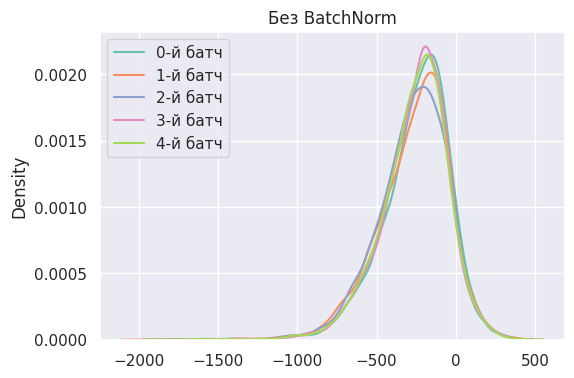

In [ ]:
plt.figure(figsize=(6, 4))
for i in range(5):
    sns.kdeplot(outputs1[i], label=f'{i}-й батч')
plt.title('Без BatchNorm')
plt.legend()
plt.show()

Распределения для отдельных батчей отличаются немного больше, чем без BatchNorm.

**Вывод**

Из данного эксперимента нелья заключить, что BatchNorm проблему ковариантного сдвига между батчами.

### 3. Dropout
Для начала добьемся переобучения модели. Это можно сделать, если использовать больше параметров в слое, дольше обучать или поменять параметры оптимизатора. Например, так:

In [ ]:
model = nn.Sequential(
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=2e-3,
)
DO_histories = []
DO_histories.append(
    train(
        model,
        criterion,
        optimizer,
        train_loader,
        test_loader,
        num_epochs=60,
        device=device,
    )
)

Epoch 60 of 60. Total time 254.274s
  training loss (in-iteration): 	0.504739
  validation loss (in-iteration): 	0.701794
  training accuracy: 			83.83 %
  validation accuracy: 			80.52 %


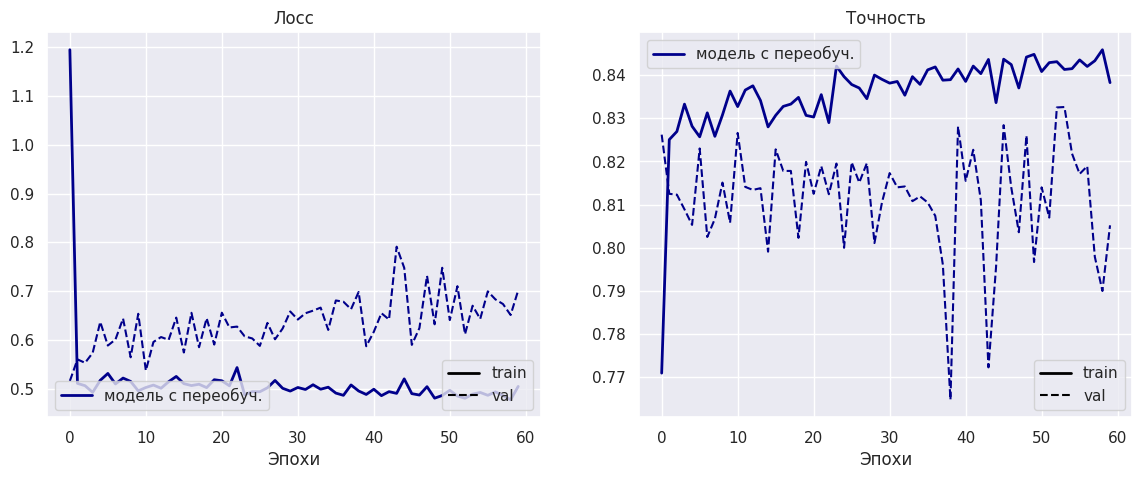

In [ ]:
plot_histories(DO_histories, ['модель с переобуч.'])

Получилось добиться переобучения.

Добавим Dropout в модель. Сравним скорость обучения и качество моделей в зависимости от параметра $p$ в Dropout.

In [ ]:
for p in (0.01, 0.05, 0.1, 0.15):
    model_do = nn.Sequential(
        nn.Linear(28 * 28, 100),
        nn.ReLU(),
        nn.Dropout(p=p),
        nn.Linear(100, 10),
    )
    optimizer = torch.optim.AdamW(
        model_do.parameters(),
        lr=2e-3,
    )
    DO_histories.append(
        train(
            model_do,
            criterion,
            optimizer,
            train_loader,
            test_loader,
            num_epochs=60,
            device=device,
        )
    )

Epoch 60 of 60. Total time 256.034s
  training loss (in-iteration): 	0.848668
  validation loss (in-iteration): 	0.758828
  training accuracy: 			69.93 %
  validation accuracy: 			74.41 %


Скорость обучения с повышением параметра p уменьшается, так как модель пересчитывает меньше параметров. Посмотрим на графики loss / accuracy:

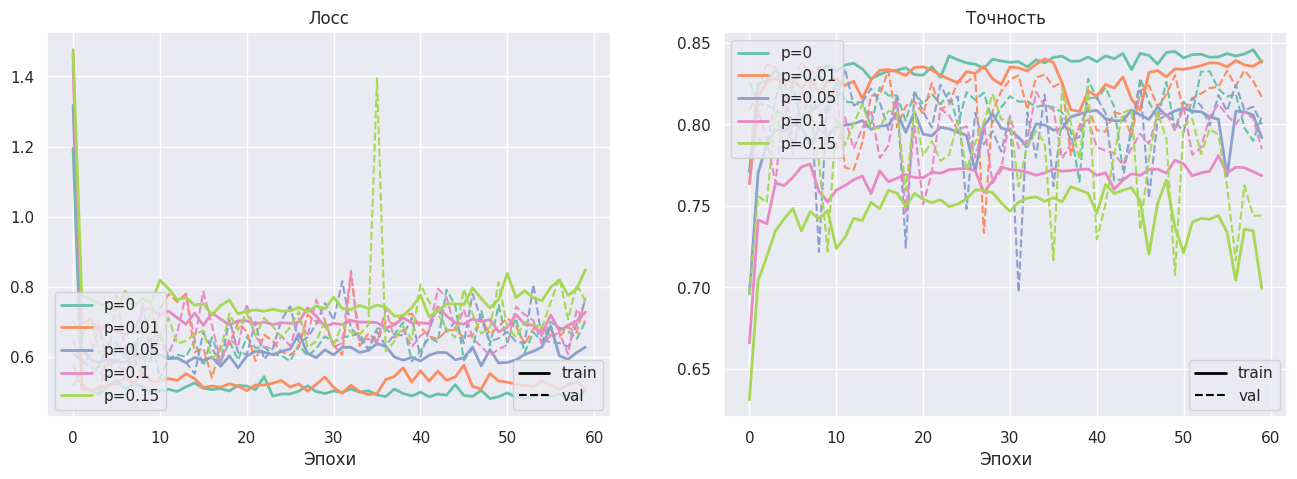

In [ ]:
plot_histories(DO_histories, ['p=0', 'p=0.01', 'p=0.05', 'p=0.1', 'p=0.15'],
               colors=pallete)

Измерим, насколько переобучаются модели в каждом случае - для этого посчитайте среднюю разность лосса на валидации и трейне (со знаком) на последних 10 или 20 эпохах.

In [ ]:
def mean_dif_last_20_epochs(history):
    return np.mean(np.array(history['loss']['val'][-20:]) - \
                   np.array(history['loss']['train'][-20:]))

In [ ]:
names = ['p=0', 'p=0.01', 'p=0.05', 'p=0.1', 'p=0.15']
for i in range(5):
    print(names[i], '\t\t', mean_dif_last_20_epochs(DO_histories[i]))

p=0 		 0.11231218587239584
p=0.01 		 0.12345217447916665
p=0.05 		 0.07772414713541666
p=0.1 		 -0.012643392740885422
p=0.15 		 -0.08699554850260416


**Вывод**  
Dropout помог избавиться от переобучения &mdash; теперь лосс на обучении не превышает лосса на валидации. Однако чем больше параметр p, тем тяжелее модели было обучаться, так как это похоже на ансамбль моделей

### 4. Регуляризация весов
Проверим распределение весов переобученной модели в пункте 3. Попробуем добиться такого эффекта переобучения, при котором возникают большие значения некоторых весов.

In [ ]:
def plot_weights(model):
    with sns.axes_style('whitegrid'):
        w1 = model[0].weight.detach().ravel().cpu()
        w2 = model[2].weight.detach().ravel().cpu()

        plt.figure(figsize=(8, 3))
        plt.subplot(1, 2, 1)
        sns.kdeplot(w1)
        plt.title(f'Веса слоя 1, max(|w|)={w1.abs().max():.2f}')
        plt.subplot(1, 2, 2)
        sns.kdeplot(w2)
        plt.title(f'Веса слоя 2, max(|w|)={w2.abs().max():.2f}')
        plt.show()

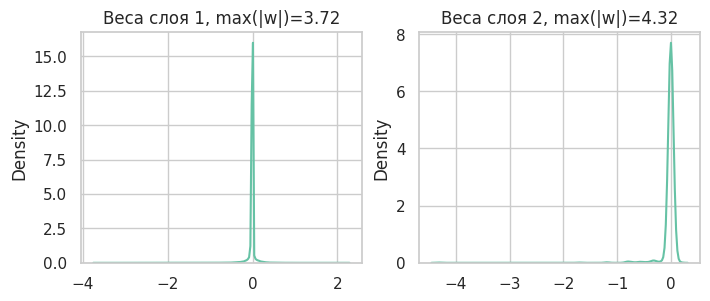

In [ ]:
plot_weights(model)

У модели уже получились достаточно большие веса по сравнению со средним, поэтому перейдем к следующему пункту.

Применим L2-регуляризацию при обучении модели. Для этого нужно указать коэффициент регуляризации через параметр `weight_deacay` в оптимизаторе.

In [ ]:
model = nn.Sequential(
    nn.Linear(28 * 28, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=2e-3,
    weight_decay=0.02
)
history_weight_dacay = train(
    model,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    num_epochs=60,
    device=device,
)

Epoch 60 of 60. Total time 250.178s
  training loss (in-iteration): 	0.520978
  validation loss (in-iteration): 	0.886208
  training accuracy: 			82.65 %
  validation accuracy: 			71.42 %


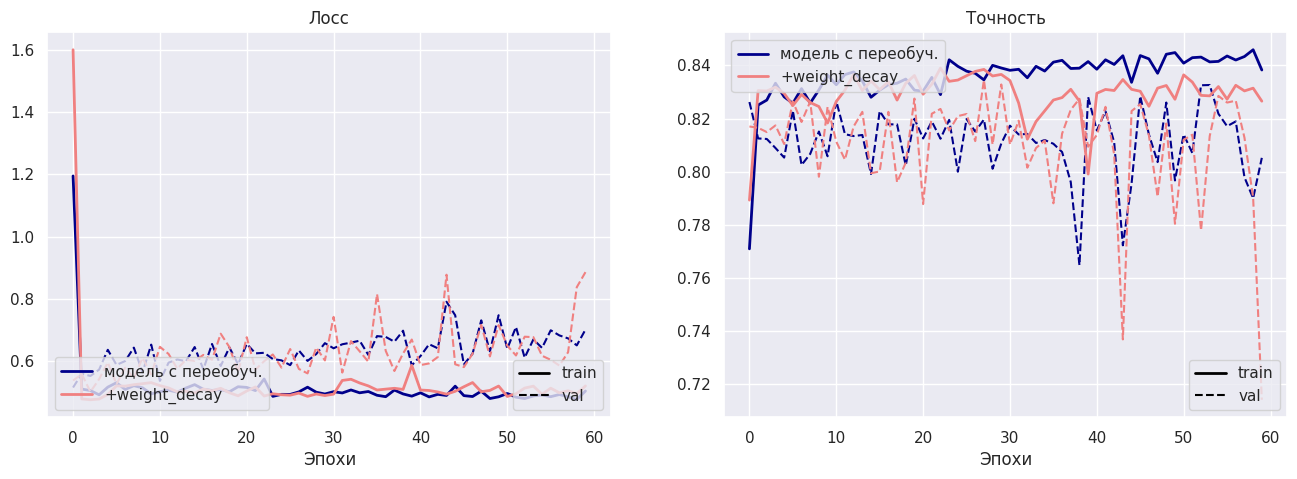

In [ ]:
plot_histories([DO_histories[0], history_weight_dacay], names=['модель с переобуч.', '+weight_decay'])

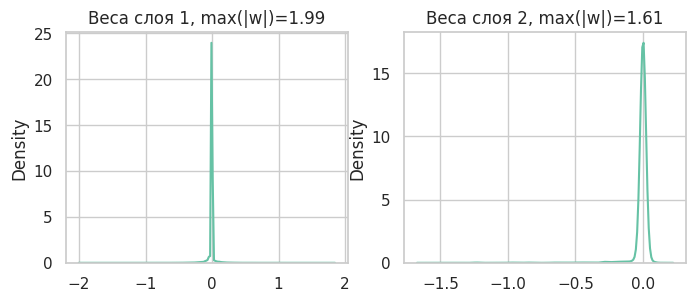

In [ ]:
plot_weights(model)

**Вывод**  
Диапазон значений весов уменьшился, эффект переобучения стал меньше.

### 5. Затухание градиента

Продемонстрируем эффект затухания градиента. Для этого будем визуализировать долю градиентов близких к нулю на каждом слое в течение обучения. Добавим в функцию обучения подсчет доли околонулевых градиентов:

In [ ]:
def train_count_zero_grads(
        model,
        criterion,
        optimizer,
        train_loader,
        val_loader,
        num_epochs,
        device,
):
    """
    # Обучение модели с подсчетом доли околонулевых градиентов
    """
    start_time = time.time()
    history = defaultdict(lambda: defaultdict(list))
    best_val_acc = 0.
    model.to(device)

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        train_size, val_size = 0, 0

        model.train()  # устанавливаем поведение dropout / batch_norm в обучение
        zero_grads = defaultdict(float)
        n_grads = defaultdict(int)

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Обучаемся на батче (одна "итерация" обучения нейросети)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()

            for name, param in model.named_parameters():
                # Будем считать градиент околонулевым, если его модуль меньше 1e-5
                zero_grads[name] += (param.grad.abs() < 1e-5).sum().item()
                n_grads[name] += np.prod(param.grad.shape)

            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.detach() * len(y_batch)
            y_pred = torch.argmax(logits, axis=1).detach()
            train_acc += (y_batch == y_pred).sum()
            train_size += len(y_batch)

        # Подсчитываем лоссы и точность, сохраням в "историю"
        train_loss = train_loss.cpu().numpy() / train_size
        train_acc = train_acc.cpu().numpy() / train_size
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
        for name, _ in model.named_parameters():
            mean_zero_grads = zero_grads[name] / n_grads[name]
            history['grad'][name].append(mean_zero_grads)

        # Устанавливаем поведение dropout / batch_norm  в тестирование
        model.eval()

        # Полный проход по валидации
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                logits = model(X_batch)
                loss = criterion(logits, y_batch)

                val_loss += loss.detach() * len(y_batch)
                y_pred = torch.argmax(logits, axis=1).detach()
                val_acc += (y_batch == y_pred).sum()
                val_size += len(y_batch)

        model.train()

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss = val_loss.cpu().numpy() / val_size
        val_acc = val_acc.cpu().numpy() / val_size
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()
        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {}. Total time {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

    return history

Построим более глубокую сеть, в качестве функций активации будем использовать гиперболический тангенс. Визуализируем долю градиентов близких к нулю на каждом слое в течение обучения.

In [ ]:
model = nn.Sequential(
    nn.Linear(28 * 28, 200),
    nn.Tanh(),
    nn.Linear(200, 150),
    nn.Tanh(),
    nn.Linear(150, 100),
    nn.Tanh(),
    nn.Linear(100, 60),
    nn.Tanh(),
    nn.Linear(60, 40),
    nn.Tanh(),
    nn.Linear(40, 20),
    nn.Tanh(),
    nn.Linear(20, 10),
)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
)
history_deep_tanh = train_count_zero_grads(
    model,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    num_epochs=30,
    device=device,
)

Epoch 30 of 30. Total time 224.848s
  training loss (in-iteration): 	0.447037
  validation loss (in-iteration): 	0.490730
  training accuracy: 			83.70 %
  validation accuracy: 			82.57 %


С глубиной качество улучшилось. Теперь визуализируем долю околонулевых градиентов:

In [ ]:
def plot_zero_grads(history, colors):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    for i, (param, param_history) in enumerate(history['grad'].items()):
      if param.find('weight') != -1:
          axs[0].plot(param_history, label=param, color=colors[i // 2], lw=2)

      elif param.find('bias') != -1:
          axs[1].plot(param_history, label=param, color=colors[i // 2], lw=2)

    axs[0].set_title('Веса')
    axs[0].set_xlabel('эпоха')
    axs[0].legend()

    axs[1].set_title('Смещения')
    axs[1].set_xlabel('эпоха')
    axs[1].legend()

    plt.show()

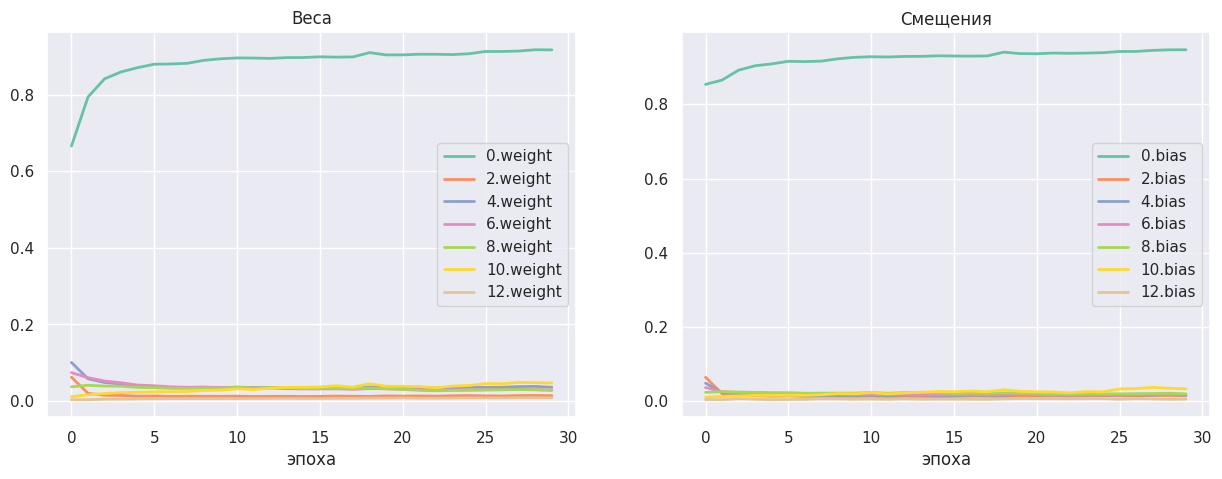

In [ ]:
plot_zero_grads(history_deep_tanh, pallete)

У первого слоя большая часть градиентов зануляется.

Попробуем решить задачу затухания градиента с помощью использования функции активации LeakyReLU.

In [ ]:
model = nn.Sequential(
    nn.Linear(28 * 28, 200),
    nn.LeakyReLU(),
    nn.Linear(200, 150),
    nn.LeakyReLU(),
    nn.Linear(150, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 60),
    nn.LeakyReLU(),
    nn.Linear(60, 40),
    nn.LeakyReLU(),
    nn.Linear(40, 20),
    nn.LeakyReLU(),
    nn.Linear(20, 10),
)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
)
history_deep_leaky = train_count_zero_grads(
    model,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    num_epochs=30,
    device=device,
)

Epoch 30 of 30. Total time 226.439s
  training loss (in-iteration): 	0.134765
  validation loss (in-iteration): 	0.402897
  training accuracy: 			95.05 %
  validation accuracy: 			88.66 %


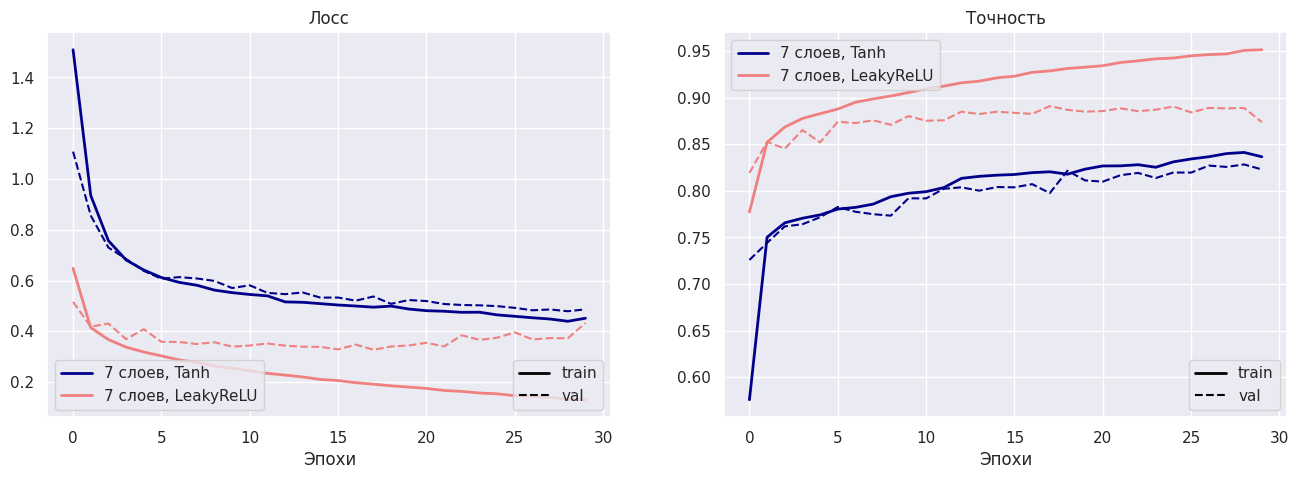

In [ ]:
plot_histories([history_deep_tanh, history_deep_leaky],
               names=['7 слоев, Tanh', '7 слоев, LeakyReLU'])

LeakyReLU показывает точность получше, но и переобучаться начинает быстрее.

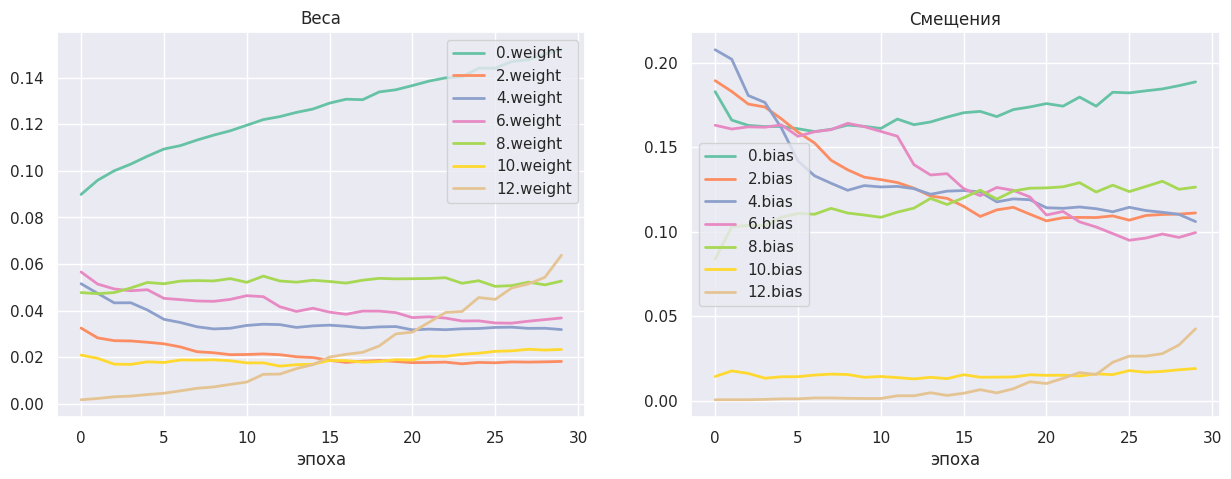

In [ ]:
plot_zero_grads(history_deep_leaky, pallete)

Благодаря LeakyReLU у первого слоя гораздо меньше градиентов стало зануляться. Возможно именно это помогло модели получить более точные прогнозы.

### Выводы
Обобщим результаты проведенных экспериментов.

1. Для задачи FasionMnist достаточно двухслойной сети, чтобы получить хорошее качество.
2. BatchNorm выполняет нормализацию выходов предыдущего слоя по батчу. Он эффективно работает если его ставить после линейного слоя перед несимметричной функцией активации типа ReLU. За счет нормализации выходов сеть может сходиться быстрее, чем без BatchNorm.
3. Dropout случайно выключает нейроны, что является регуляризацией модели. Благодаря Dropout можно решить проблему переобучения модели, однако он замедляет скорость обучения.
4. Проблему переобучения можно решить регуляризацией, если это связано с большими значениями весов.
5. LeakyReLU позволяет решить проблему затухающих градиентов.